# Single cell level analysis, B cells

**Top Note:** we should consider normalise the library size (labelled as `exp_sum_count` or `total_counts`) with predefined coefficient weight as 1.

$$y \sim NB(\mu, \phi)$$
$$\log(\mu) = w_0 * 1 + w_1 * condition + 1 * total\_counts$$

You may use your implemement and fit this parameter (it should be close enough to 1) or use 
[statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.NegativeBinomial.html)
by setting it as `exposure`:

```Python
NB_glm = sm.discrete.discrete_model.NegativeBinomial(
    obs_y, feature_x,                                                         
    loglike_method = 'nb2', 
    exposure = sample_libsize, 
    offset = None, 
    missing = 'none', 
    check_rank = True
)
```

For negative binomial likelihood, check [aod R package](https://rdrr.io/cran/aod/man/negbin.html).

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.io import mmread
from statsmodels.discrete.discrete_model import NegativeBinomial
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, '../NegabinGLM')

import NegativeBinomial as NB

In [2]:
# create a repository for the data
!mkdir ../write_data/write_data_cell_B
path = '../write_data/write_data_cell_B/'

## Load genes

In [3]:
df_genes = pd.read_csv('../data/NPC_NLH-genes.tsv', sep='\t')
df_genes

,gene_names,gene_ids
0,HES5,ENSG00000197921
1,TP73,ENSG00000078900
2,HES2,ENSG00000069812
3,PAX7,ENSG00000009709
4,E2F2,ENSG00000007968
...,...,...
614,OLIG1,ENSG00000184221
615,RUNX1,ENSG00000159216
616,ERG,ENSG00000157554
617,ETS2,ENSG00000157557


## Load sc level B cells

In [4]:
Y_cell_B_mat = mmread('../data/NPC_NLH-Bcell-Y.mtx')
Y_cell_B = Y_cell_B_mat.A
Y_cell_B.shape

(24296, 619)

In [5]:
# create a df using Y_cell_B, and add gene names as column names
df_Y_cell_B = pd.DataFrame(Y_cell_B)
df_Y_cell_B.columns = df_genes['gene_names']

# change column 'gene_names' to 'idx'
df_Y_cell_B = df_Y_cell_B.rename(columns={'gene_names': 'idx'})
df_Y_cell_B

gene_names,HES5,TP73,HES2,PAX7,E2F2,RUNX3,TFAP2E,MTF1,POU3F1,ZNF684,...,TEF,SREBF2,GABPA,BACH1,OLIG2,OLIG1,RUNX1,ERG,ETS2,PKNOX1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24292,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
24293,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
24294,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
Y_cell_B = df_Y_cell_B

In [6]:
X_cell_B = pd.read_csv('../data/NPC_NLH-Bcell-X.tsv', sep='\t')
X_cell_B

,cell_id,patient_ID,condition,exp_sum_count
0,CACCACTAGGAGTCTG-11,11,NLH,3803.0
1,GACTAACGTCGGCTCA-9,9,NPC,3575.0
2,GCAGCCAGTAGCCTCG-5,5,NPC,547.0
3,CACAAACGTCAGGACA-2,2,NPC,3353.0
4,TACGGTATCTCAACTT-1,1,NPC,2762.0
...,...,...,...,...
24566,CTAATGGGTGACTACT-1,1,NPC,4117.0
24567,CAAGAAAAGGCACATG-3,3,NPC,607.0
24568,CACATTTGTGCTCTTC-10,10,NPC,6192.0
24569,CATGGCGAGAGCAATT-10,10,NPC,4793.0


filter gene with 0 total counts

In [9]:
# filter out genes with zero counts in all cells
Y_cell_B = Y_cell_B.loc[:, (Y_cell_B != 0).any(axis=0)]
Y_cell_B

gene_names,HES5,TP73,E2F2,RUNX3,TFAP2E,MTF1,POU3F1,ZNF684,NFYC,FOXO6,...,MAFF,ATF4,TEF,SREBF2,GABPA,BACH1,RUNX1,ERG,ETS2,PKNOX1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24291,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24292,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
24293,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,1,0,0,0
24294,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


change condition to binary

In [10]:
# add a binary condition column, 1 for NPC, 0 for NLH
X_cell_B['condition_bi'] = np.where(X_cell_B['condition']=='NPC', 1, 0)
X_cell_B['log_tc'] = np.log(X_cell_B['exp_sum_count'])
X_cell_B

,cell_id,patient_ID,condition,exp_sum_count,condition_bi,log_tc
0,CACCACTAGGAGTCTG-11,11,NLH,3803.0,0,8.243546
1,GACTAACGTCGGCTCA-9,9,NPC,3575.0,1,8.181720
2,GCAGCCAGTAGCCTCG-5,5,NPC,547.0,1,6.304449
3,CACAAACGTCAGGACA-2,2,NPC,3353.0,1,8.117611
4,TACGGTATCTCAACTT-1,1,NPC,2762.0,1,7.923710
...,...,...,...,...,...,...
24566,CTAATGGGTGACTACT-1,1,NPC,4117.0,1,8.322880
24567,CAAGAAAAGGCACATG-3,3,NPC,607.0,1,6.408529
24568,CACATTTGTGCTCTTC-10,10,NPC,6192.0,1,8.731013
24569,CATGGCGAGAGCAATT-10,10,NPC,4793.0,1,8.474912


In [11]:
X_cell_B_NB1 = X_cell_B[['condition_bi', 'log_tc']] # X of L1, NB model
X_cell_B_NB0 = X_cell_B[['log_tc']] # X of L0, NB model

X_cell_B_NB0 = sm.add_constant(X_cell_B_NB0)
X_cell_B_NB1 = sm.add_constant(X_cell_B_NB1)

In [12]:
X_cell_B_NB0

,const,log_tc
0,1.0,8.243546
1,1.0,8.181720
2,1.0,6.304449
3,1.0,8.117611
4,1.0,7.923710
...,...,...
24566,1.0,8.322880
24567,1.0,6.408529
24568,1.0,8.731013
24569,1.0,8.474912


Fit NegBin models 

L1:
$$\log(\mu) = w_0 * 1 + w_1 * condition + 1 * total\_counts$$
L0 (NULL): 
$$\log(\mu) = w_0 * 1 + 1 * total\_counts$$

The `llr_pvalue` is the p value of the log likelihood ratio test on L0 and L1

In [13]:
ll0_cell_B = np.zeros(Y_cell_B.shape[1])
ll1_cell_B = np.zeros(Y_cell_B.shape[1])

NB_Reg module

In [14]:
for i in range(Y_cell_B.shape[1]):

    Y_genes = Y_cell_B.iloc[:, i]

    L1_NB = NB.NB_Reg(X_cell_B_NB1, Y_genes)
    L0_NB = NB.NB_Reg(X_cell_B_NB0, Y_genes)
    
    L1_NB.fit_w_exp()
    L0_NB.fit_w_exp()
    L1_NB.fit_phi()
    L0_NB.fit_phi()

    ll0_cell_B[i] = -1 * L0_NB.optimize_record_phi.fun
    ll1_cell_B[i] = -1 * L1_NB.optimize_record_phi.fun

    if i % 50 == 0:
        print(i)

ValueError: operands could not be broadcast together with shapes (24296,) (24571,) 

LRT

In [15]:
lrt_statistic_cell_B = 2 * (ll1_cell_B - ll0_cell_B)
p_val_cell_B = sp.stats.chi2.sf(lrt_statistic_cell_B, 1)
p_val_cell_B

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [26]:
p_val_cell_B.shape

(466,)

In [27]:
from statsmodels.stats.multitest import fdrcorrection
p_val_corrected_cell_B = fdrcorrection(p_val_cell_B, alpha=0.05, method='indep', is_sorted=False)[1]
p_val_corrected_cell_B.shape

(466,)

In [28]:
# create a dataframe, store gene names, p values, and corrected p values
# use gene names from Y_cell_B
df_pval_cell_B = pd.DataFrame({'gene': Y_cell_B.columns, 'p_val': p_val_cell_B, 'p_val_corrected': p_val_corrected_cell_B})

In [29]:
# rank genes by p_val_corrected, ascending order
df_pval_cell_B = df_pval_cell_B.sort_values(by=['p_val_corrected'])
df_pval_cell_B

,gene,p_val,p_val_corrected
351,TBX21,0.000000,0.0
189,EGR3,0.000000,0.0
188,ZNF449,0.000000,0.0
43,ZBTB18,0.000000,0.0
350,MEOX1,0.000000,0.0
...,...,...,...
96,NFKB1,1.000000,1.0
93,KLF3,1.000000,1.0
368,TGIF1,1.000000,1.0
66,STAT1,1.000000,1.0


Plot the distribution of corrected p values

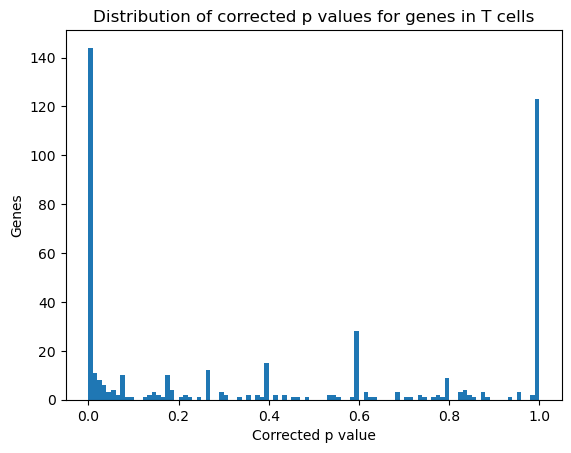

In [30]:
# bar plot the p_val_corrected
genes = np.linspace(1, len(df_pval_cell_B), len(df_pval_cell_B))
plt.hist(df_pval_cell_B['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in B cells')
plt.savefig(path + 'p_val_corrected_cell_B.png')
plt.show()

In [41]:
# filter genes with corrected p value = 1
df_pval_cell_B_filtered = df_pval_cell_B[df_pval_cell_B['p_val_corrected'] != 1]
df_pval_cell_B_filtered

,gene,p_val,p_val_corrected
351,TBX21,0.000000,0.000000
189,EGR3,0.000000,0.000000
188,ZNF449,0.000000,0.000000
43,ZBTB18,0.000000,0.000000
350,MEOX1,0.000000,0.000000
...,...,...,...
235,PAX6,0.700201,0.956994
339,HES7,0.700271,0.956994
464,ETS2,0.723737,0.983270
448,ZNF8,0.722899,0.983270


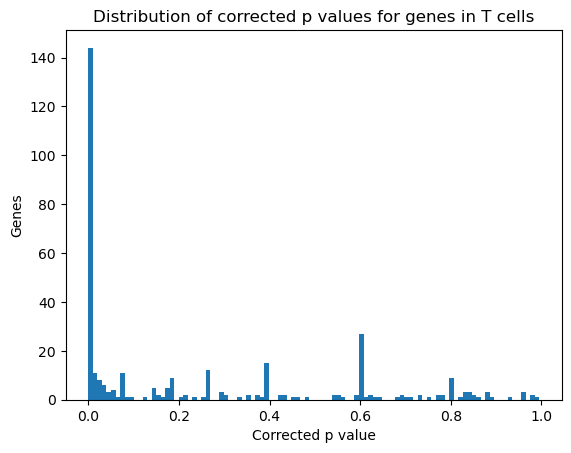

In [32]:
# bar plot the p_val_corrected
genes = np.linspace(1, len(df_pval_cell_B_filtered), len(df_pval_cell_B_filtered))
plt.hist(df_pval_cell_B_filtered['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in T cells')
plt.show()

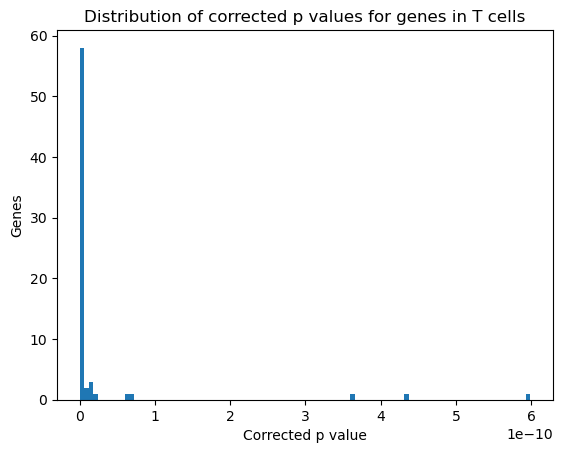

In [42]:
df_pval_cell_B_filtered = df_pval_cell_B_filtered[df_pval_cell_B_filtered['p_val_corrected'] < 0.000000001]
genes = np.linspace(1, len(df_pval_cell_B_filtered), len(df_pval_cell_B_filtered))
plt.hist(df_pval_cell_B_filtered['p_val_corrected'], bins=100)
plt.ylabel('Genes')
plt.xlabel('Corrected p value')
plt.title('Distribution of corrected p values for genes in T cells')
plt.savefig(path + 'p_val_corrected_cell_B_filtered.png')
plt.show()

In [48]:
top_genes_cell_B = df_pval_cell_B_filtered[df_pval_cell_B_filtered['p_val_corrected'] < 1e-10]
top_genes_cell_B

,gene,p_val,p_val_corrected
351,TBX21,0.000000e+00,0.000000e+00
189,EGR3,0.000000e+00,0.000000e+00
188,ZNF449,0.000000e+00,0.000000e+00
43,ZBTB18,0.000000e+00,0.000000e+00
350,MEOX1,0.000000e+00,0.000000e+00
...,...,...,...
67,KLF7,2.122025e-12,1.569625e-11
37,ELK4,2.100973e-12,1.569625e-11
244,ETS1,2.958078e-12,2.153851e-11
285,KLF5,8.441666e-12,6.052025e-11


In [53]:
# find df_cell_B columns that correspond to the top genes, keep condition
df_cell_B_top_genes = Y_cell_B[top_genes_cell_B['gene']]
df_cell_B_top_genes['condition'] = X_cell_B['condition']
# move condition column to the front
cols = df_cell_B_top_genes.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_cell_B_top_genes = df_cell_B_top_genes[cols]
# change 'gene_names' to 'idx'
df_cell_B_top_genes = df_cell_B_top_genes.rename(columns={'gene_names': 'idx'})
df_cell_B_top_genes #final top gene result

/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_18620/3294842334.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cell_T_top_genes['condition'] = X_cell_T['condition']


gene_names,condition,TBX21,EGR3,ZNF449,ZBTB18,MEOX1,RREB1,ETV3,NFIA,ZNF135,...,GLIS3,ZBTB32,MYBL1,TP73,PLAG1,KLF7,ELK4,ETS1,KLF5,E2F7
0,NLH,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NPC,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24566,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
24567,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24568,NPC,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
24569,NPC,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [54]:
# save the top genes to a tsv file
df_cell_B_top_genes.to_csv(path + 'NPC_NLH_cell_B_top_genes.tsv', sep='\t')
top_genes_cell_B.to_csv( path + 'NPC_NLH_cell_B_top_genes_ranking.tsv', sep='\t')

heatmap

In [55]:
# add total_counts column, total_counts = sum of counts of all genes
df_cell_B_top_genes['total_counts'] = df_cell_B_top_genes.sum(axis=1)
df_cell_B_top_genes

/var/folders/ms/kqznsr6n6934_wtng0twy8dw0000gn/T/ipykernel_18620/4136342573.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_cell_T_top_genes['total_counts'] = df_cell_T_top_genes.sum(axis=1)


gene_names,condition,TBX21,EGR3,ZNF449,ZBTB18,MEOX1,RREB1,ETV3,NFIA,ZNF135,...,ZBTB32,MYBL1,TP73,PLAG1,KLF7,ELK4,ETS1,KLF5,E2F7,total_counts
0,NLH,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
1,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,NPC,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,2,0,0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24566,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,9
24567,NPC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,2
24568,NPC,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,1,0,0,7
24569,NPC,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,8


In [56]:
# sum the counts of the top genes for condition NPC and NLH, normalize each gene
df_cell_B_top_genes_heatmap = df_cell_B_top_genes.groupby('condition').sum()
# normalize each gene by dividing each gene by total_counts
df_cell_B_top_genes_heatmap = df_cell_B_top_genes_heatmap.div(df_cell_B_top_genes_heatmap['total_counts'], axis=0)
# drop total_counts column
df_cell_B_top_genes_heatmap = df_cell_B_top_genes_heatmap.drop(columns=['total_counts'])
df_cell_B_top_genes_heatmap

gene_names,TBX21,EGR3,ZNF449,ZBTB18,MEOX1,RREB1,ETV3,NFIA,ZNF135,NR3C1,...,GLIS3,ZBTB32,MYBL1,TP73,PLAG1,KLF7,ELK4,ETS1,KLF5,E2F7
condition,,,,,,,,,,,,,,,,,,,,,
NLH,0.008718,0.004000,0.002587,0.001437,0.004479,0.007712,0.009987,0.006442,0.000287,0.082409,...,0.001102,0.004383,0.005484,0.000216,0.005604,0.003281,0.014082,0.071057,0.003066,0.000407
NPC,0.009410,0.002249,0.001211,0.001090,0.007551,0.003875,0.006591,0.003728,0.000562,0.130040,...,0.000112,0.006158,0.002171,0.001090,0.002249,0.004835,0.015205,0.063891,0.000969,0.001349


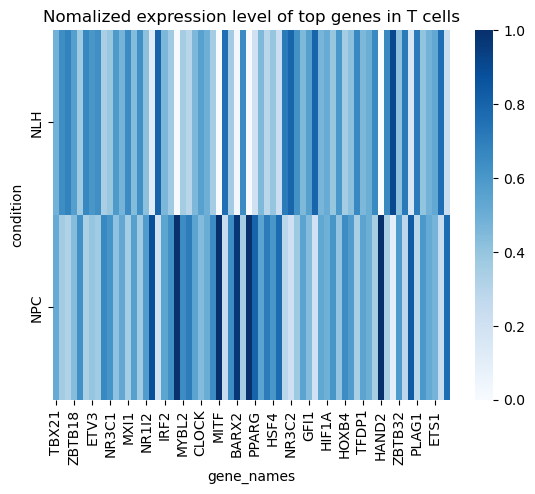

In [58]:
# normalize each gene by dividing each gene by the sum of the column
df_cell_B_top_genes_heatmap = df_cell_B_top_genes_heatmap.div(df_cell_B_top_genes_heatmap.sum(axis=0), axis=1)

# heatmap
sns.heatmap(df_cell_B_top_genes_heatmap, cmap='Blues')
plt.title('Nomalized expression level of top genes in T cells')
plt.savefig(path + 'top_genes_cell_B_heatmap.png')
plt.show()